In [8]:
%config IPCompleter.greedy=True
import pandas as pd
import nltk.data
import re, string, unicodedata
import nltk
import matplotlib.pyplot as plt
import time

from unicodedata import normalize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

arrayHeaders = ["Area", "Dimension", "Respuesta"]
df = pd.read_csv("Data/formattedData.csv", sep=";")

In [2]:
# gs = goslate.Goslate(service_urls=['http://translate.google.es'])

# def verfLengEs(text):
#     if text.isdigit()== False and len(text) > 10:
#         time.sleep(10)
#         leng = gs.detect(text)
#         print(leng)
#         if 'es' == leng:
#             return text
#         else:
#             return ''
#     else:
#         return text
    
#df["Respuesta"][0:100] = df["Respuesta"][0:100].apply(verfLengEs)

In [10]:
dataSentTokenized = df.dropna().copy()
dataSentTokenized["Respuesta"] = dataSentTokenized["Respuesta"].apply(nltk.sent_tokenize)
dataSentTokenized = dataSentTokenized[dataSentTokenized['Respuesta'].map(len) >= 1].copy()
dataSentTokenized = dataSentTokenized.dropna()

In [11]:
arrayExterno = []
def separeSentences(row):
    if type(row['Respuesta']) != str:
        if len(row['Respuesta']) == 1:
            row['Respuesta'] = row['Respuesta'][0]
            return row
        else:
            area = row['Area']
            dimension = row['Dimension']
            for sent in row['Respuesta']:
                tempArray = []
                tempArray.append(area)    
                tempArray.append(dimension)
                tempArray.append(sent)
                arrayExterno.append(tempArray)
            row['Respuesta'] = ""
            return row
    else:
        return row

dataSentTokenized = dataSentTokenized.apply(separeSentences, axis = 1)

In [12]:
dataFrameSentencesSepared = pd.concat([dataSentTokenized,pd.DataFrame(arrayExterno, columns=arrayHeaders)], ignore_index=True) 

In [13]:
def deleteSimbols(tokens):
    return re.sub(r'[^\w\s]', ' ', tokens)
dataFrameSentencesSepared["Respuesta"] = dataFrameSentencesSepared["Respuesta"].apply(deleteSimbols)

In [14]:
dataFrameWordSepared = dataFrameSentencesSepared.copy() 
dataFrameWordSepared["Respuesta"] = dataFrameWordSepared["Respuesta"].apply(nltk.word_tokenize)

In [15]:
largoRespuestas1 = dataFrameWordSepared["Respuesta"].apply(len)
largoRespuestas1.describe()

count    344304.000000
mean          8.152685
std           8.661278
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         306.000000
Name: Respuesta, dtype: float64

In [18]:
stop = stopwords.words('spanish')
def verifyStopWords(tokens):
    for token in tokens:
        if token.lower() in stop:
            tokens.pop(tokens.index(token))
    return tokens

In [20]:
dataTestStop = dataFrameWordSepared.copy()
dataTestStop["Respuesta"] = dataTestStop["Respuesta"].apply(verifyStopWords)

In [21]:
def verifyVoidElements(tokens):
    for token in tokens:
        if token == '' or token == " " or token == "  ":
            tokens.pop(tokens.index(token))
    return tokens

In [22]:
dfMoreWords = dataTestStop.copy()
dfMoreWords["Respuesta"] = dfMoreWords["Respuesta"].apply(verifyVoidElements)
dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) > 3].copy()
dfMoreWords = dfMoreWords.dropna()

In [24]:
def normalizeTokens(tokens):
    for token in tokens:
        pos = tokens.index(token)
        if token.isdigit():
            tokens[pos] = ""#num2words(token, lang='es')
        else:
            token = re.sub(r'[^\w\s]', ' ', token)
            if token != ' ' or token != '':
                tokens[pos] = unicodedata.normalize('NFKD', token.lower()).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            else:
                tokens.pop(pos)
    return tokens

In [25]:
dfNormalized = dfMoreWords.copy()
dfNormalized["Respuesta"] = dfNormalized['Respuesta'].apply(normalizeTokens)
dfNormalized["Respuesta"] = dfNormalized['Respuesta'].apply(verifyVoidElements)

In [26]:
DataFinalFlujo1 = dfNormalized.copy()
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1["Respuesta"].apply(verifyStopWords)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verifyVoidElements)

In [27]:
def verify_spacing_and_numbers(tokens):
    for token in tokens:
        if token.isalpha() == False:
            tokens.pop(tokens.index(token))
    return tokens

DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1['Respuesta'].apply(verify_spacing_and_numbers)

In [28]:
def verify_(tokens):
    for token in tokens:
        if token.isalpha() == False:
            print(token,tokens.index(token), len(token))
    return tokens
a = DataFinalFlujo1['Respuesta'].apply(verify_)

In [29]:
DataFinalFlujo1["Respuesta"].apply(len).describe()

count    165199.000000
mean          7.312345
std           4.552516
min           0.000000
25%           5.000000
50%           6.000000
75%           8.000000
max         155.000000
Name: Respuesta, dtype: float64

In [30]:
lemmaDiccionario = {}
with open('Herramientas/lemma.txt', 'rb') as fichero:
    datos = (fichero.read().decode('utf8').replace(u'\r', u'').split(u'\n'))
    datos = ([avance.split(u'\t') for avance in datos])
for avance in datos:
   if len(avance) >1:
      lemmaDiccionario[avance[1]] = avance[0]
        
def lemmatize(word):
   return lemmaDiccionario.get(word, word + u'')
   
def lemmatize_words(words):
    new_words = []
    for palabra in words:
        new_word = lemmatize(palabra)
        new_words.append(new_word)
    return new_words

In [31]:
DataFinalFlujo1["Respuesta"] = DataFinalFlujo1["Respuesta"].apply(lemmatize_words)

In [32]:
largoRespuestas2 = DataFinalFlujo1["Respuesta"].apply(len)
largoRespuestas2.describe()

count    165199.000000
mean          7.312345
std           4.552516
min           0.000000
25%           5.000000
50%           6.000000
75%           8.000000
max         155.000000
Name: Respuesta, dtype: float64

In [33]:
dfMoreWords = DataFinalFlujo1.copy()
dfMoreWords["Respuesta"] = dfMoreWords['Respuesta'].apply(verifyVoidElements)
dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) > 3]
#dfMoreWords = dfMoreWords[dfMoreWords['Respuesta'].map(len) <= 15]
dfMoreWords = dfMoreWords.dropna()

In [34]:
def return10first(token):
    if(len(token) > 10):
        return token[0:10]
    else:
        return token
dfMoreWords["Respuesta"] = dfMoreWords["Respuesta"].apply(return10first)

In [35]:
largoRespuestas3 = dfMoreWords['Respuesta'].apply(len)
largoRespuestas3.describe()

count    162941.000000
mean          6.556447
std           2.211528
min           4.000000
25%           5.000000
50%           6.000000
75%           9.000000
max          10.000000
Name: Respuesta, dtype: float64

In [36]:
largoRespuestas3 = dfMoreWords['Respuesta'].apply(len)
largoRespuestas3.describe()

count    162941.000000
mean          6.556447
std           2.211528
min           4.000000
25%           5.000000
50%           6.000000
75%           9.000000
max          10.000000
Name: Respuesta, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x25496db45c0>,
 'caps': [<matplotlib.lines.Line2D at 0x254a32d3f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x254a32d05c0>],
 'medians': [<matplotlib.lines.Line2D at 0x254a32d3438>],
 'fliers': [<matplotlib.lines.Line2D at 0x254a32d31d0>],
 'means': []}

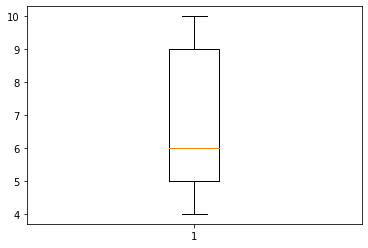

In [37]:
plt.subplots()
dataToPlot = [largoRespuestas3]
plt.boxplot(dataToPlot)

In [38]:
dfMoreWords.to_csv("Data/Flujo1.csv", sep=";", index=False)

#Fin Flujo 1

In [41]:
dfMoreWords.groupby(['Area','Dimension']).count().Respuesta

Area                  Dimension                   
Confianza General     Confianza General               11753
                      Información Adicional             979
                      Infraestructura                    45
                      Innovación                        515
Gobierno Corporativo  Anti-corrupción                  6938
                      Control Riesgos                    35
                      Cultura Ambiental                  74
                      Estrategia de Negocio             168
                      Estructura Directorio              51
                      Estructura Ejecutiva               17
                      Grupo Investor                     58
                      Integridad                       7115
                      Investors Day                      13
                      Legal                               9
                      Transparencia Información          30
                      Trato Accionistas          

In [42]:
dfMoreWords[dfMoreWords['Area'] == 'Social Interno'][dfMoreWords['Dimension'] != 'Administración']

C:\Users\ralvarez\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Area,Dimension,Respuesta
94851,Social Interno,Beneficios,"[empresa, vario, beneficio, seguro, salud, vid..."
94852,Social Interno,Beneficios,"[importante, beneficio, si, valorar, creer]"
94853,Social Interno,Beneficios,"[beneficio, estan, bien, acorde, deberia, ser]"
94856,Social Interno,Beneficios,"[seguro, complementario, salud, excelente]"
94858,Social Interno,Beneficios,"[seguro, salud, complementario, alto, calidad]"
94861,Social Interno,Beneficios,"[valorar, ver, esforzar, detras]"
94862,Social Interno,Beneficios,"[beneficio, poco, respectar, banco, ser, mismo..."
94863,Social Interno,Desarrollo,"[bueno, oportunidad, desarrollar, carrera, pro..."
94864,Social Interno,Desarrollo,"[deber, area, trabajar, dificil, desarrollar, ..."
94865,Social Interno,Desarrollo,"[sentir, interesar, poder, crecer, dentro, emp..."
